# Tutoriel Open Classroom : Classifiez vos données avec une SVM à noyau

In [27]:
# Importation des bibliothèques Python
import numpy as np
import pandas as pd

# Importation des données
white_wine = pd.read_csv('./Data/winequality-white.csv', sep=';')
white_wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [28]:
# créer la matrice de données
X = white_wine[white_wine.columns[:-1]].values

# créer le vecteur d'étiquettes
y = white_wine['quality'].values

# transformer en un problème de classification binaire
y_class = np.where(y<6, 0, 1)

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.3)

In [30]:
# standardiser les données
from sklearn.preprocessing import StandardScaler
std_scale = StandardScaler().fit(X_train)

X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

In [31]:
# Créer une SVM avec un noyau gaussien de paramètre gamma=0.01
from sklearn import svm
classifier = svm.SVC(kernel='rbf', gamma=0.01)

# Entraîner la SVM sur le jeu d'entraînement
classifier.fit(X_train_std, y_train)

SVC(gamma=0.01)

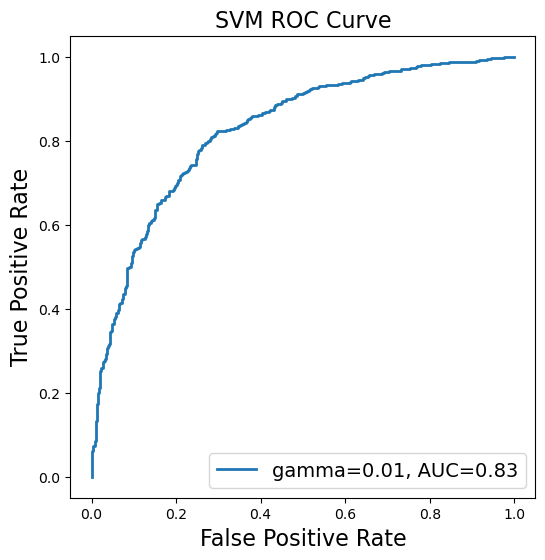

In [32]:
# prédire sur le jeu de test
y_test_pred = classifier.decision_function(X_test_std)

# construire la courbe ROC
from sklearn import metrics
fpr, tpr, thr = metrics.roc_curve(y_test, y_test_pred)

# calculer l'aire sous la courbe ROC
auc = metrics.auc(fpr, tpr)

# créer une figure
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(6, 6))

# afficher la courbe ROC
plt.plot(fpr, tpr, '-', lw=2, label='gamma=0.01, AUC=%.2f' % auc)

# donner un titre aux axes et au graphique
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('SVM ROC Curve', fontsize=16)

# afficher la légende
plt.legend(loc="lower right", fontsize=14)

# afficher l'image
plt.show()

In [33]:
from sklearn.model_selection import GridSearchCV

# choisir 6 valeurs pour C, entre 1e-2 et 1e3
C_range = np.logspace(-2, 3, 6)

# choisir 4 valeurs pour gamma, entre 1e-2 et 10
gamma_range = np.logspace(-2, 1, 4)

# grille de paramètres
param_grid = {'C': C_range, 'gamma': gamma_range}

# critère de sélection du meilleur modèle
score = 'roc_auc'

# initialiser une recherche sur grille
grid = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=5, scoring=score)

# faire tourner la recherche sur grille
grid.fit(X_train_std, y_train)

# afficher les paramètres optimaux
print("The optimal parameters are {} with a score of {:.2f}".format(grid.best_params_, grid.best_score_))

The optimal parameters are {'C': 1.0, 'gamma': 1.0} with a score of 0.84


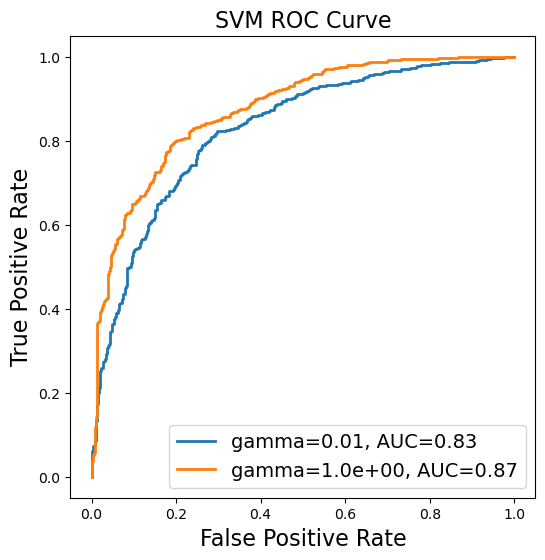

In [34]:
# prédire sur le jeu de test avec le modèle optimisé
y_test_pred_cv = grid.decision_function(X_test_std)

# construire la courbe ROC du modèle optimisé
fpr_cv, tpr_cv, thr_cv = metrics.roc_curve(y_test, y_test_pred_cv)

# calculer l'aire sous la courbe ROC du modèle optimisé
auc_cv = metrics.auc(fpr_cv, tpr_cv)

# créer une figure
fig = plt.figure(figsize=(6, 6))

# afficher la courbe ROC précédente
plt.plot(fpr, tpr, '-', lw=2, label='gamma=0.01, AUC=%.2f' % auc)

# afficher la courbe ROC du modèle optimisé
plt.plot(fpr_cv, tpr_cv, '-', lw=2, label='gamma=%.1e, AUC=%.2f' % \
         (grid.best_params_['gamma'], auc_cv))
         

# donner un titre aux axes et au graphique
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('SVM ROC Curve', fontsize=16)

# afficher la légende
plt.legend(loc="lower right", fontsize=14)

# afficher l'image
plt.show()

In [35]:
from sklearn import metrics
kmatrix = metrics.pairwise.rbf_kernel(X_train_std, gamma=0.01)

In [36]:
kmatrix100 = kmatrix[:100, :100]

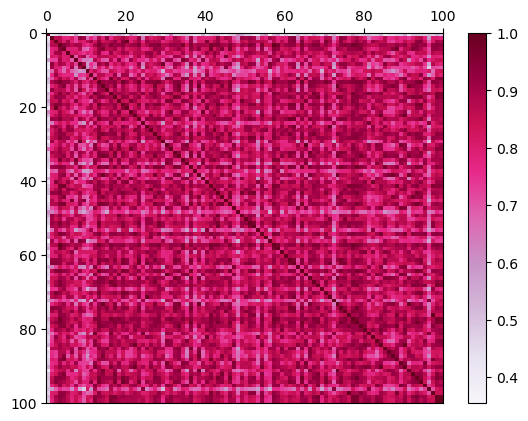

In [37]:
import matplotlib

# dessiner la matrice
plt.pcolor(kmatrix100, cmap = matplotlib.cm.PuRd)

# rajouter la légende
plt.colorbar()

# retourner l'axe des ordonnées
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()

# afficher l'image
plt.show()

# Exercice - Tutoriel Open Classroom : Classifiez vos données avec une SVM à noyau

In [38]:
# Chargement des données des électrocardiogrammes
data_ecg = pd.read_csv('./Data/ecg.csv', header=None)
data_ecg

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,0.608558,-0.335651,-0.990948,-1.784153,-2.626145,-2.957065,-2.931897,-2.664816,-2.090137,-1.461841,...,1.757705,2.291923,2.704595,2.451519,2.017396,1.704358,1.688542,1.629593,1.342651,0.0
4994,-2.060402,-2.860116,-3.405074,-3.748719,-3.513561,-3.006545,-2.234850,-1.593270,-1.075279,-0.976047,...,1.388947,2.079675,2.433375,2.159484,1.819747,1.534767,1.696818,1.483832,1.047612,0.0
4995,-1.122969,-2.252925,-2.867628,-3.358605,-3.167849,-2.638360,-1.664162,-0.935655,-0.866953,-0.645363,...,-0.472419,-1.310147,-2.029521,-3.221294,-4.176790,-4.009720,-2.874136,-2.008369,-1.808334,0.0
4996,-0.547705,-1.889545,-2.839779,-3.457912,-3.929149,-3.966026,-3.492560,-2.695270,-1.849691,-1.374321,...,1.258419,1.907530,2.280888,1.895242,1.437702,1.193433,1.261335,1.150449,0.804932,0.0


In [39]:
# Vérification de l'équilibrage des données
data_ecg[140].value_counts()

1.0    2919
0.0    2079
Name: 140, dtype: int64

In [40]:
# Création de la matrice de données
X = data_ecg[data_ecg.columns[:-1]].values

# Création des vecteur d'étiquettes
y = data_ecg[140].values

In [41]:
# Séparation des données en trainsets et testsets
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.3)

ValueError: Found input variables with inconsistent numbers of samples: [4998, 4898]

In [ ]:
# Standardization des données
std_scale = StandardScaler().fit(X_train)

X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

In [ ]:
# Création d'une SVM
classifier = svm.SVC(kernel='rbf', gamma=50)

# Entraîner la SVM sur le jeu d'entraînement
classifier.fit(X_train_std, y_train)

SVC(gamma=50)

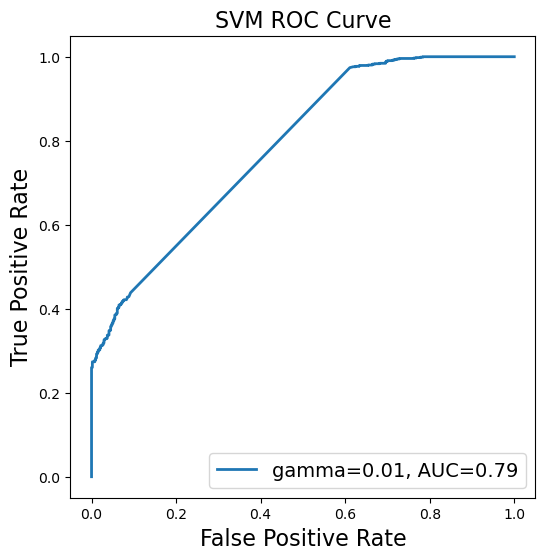

In [ ]:
# prédire sur le jeu de test
y_test_pred = classifier.decision_function(X_test_std)

# construire la courbe ROC
fpr, tpr, thr = metrics.roc_curve(y_test, y_test_pred)

# calculer l'aire sous la courbe ROC
auc = metrics.auc(fpr, tpr)

# créer une figure
fig = plt.figure(figsize=(6, 6))

# afficher la courbe ROC
plt.plot(fpr, tpr, '-', lw=2, label='gamma=0.01, AUC=%.2f' % auc)

# donner un titre aux axes et au graphique
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('SVM ROC Curve', fontsize=16)

# afficher la légende
plt.legend(loc="lower right", fontsize=14)

# afficher l'image
plt.show()